In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as tdist

## Defining cells

In [0]:
class RNNCell(nn.Module):
    """A vanilla RNN cell
    
    An RNN cell which takes two inputs: x and previous hidden state
    and outputs the current hidden state and output.
    
    The RNN cell can be used as components for the following designs:
    * One-to-one: https://stanford.edu/~shervine/images/rnn-one-to-one.png
    * One-to-many: https://stanford.edu/~shervine/images/rnn-one-to-many.png
    * Many-to-one: https://stanford.edu/~shervine/images/rnn-many-to-one.png
    * Many-to-many
        * Same: https://stanford.edu/~shervine/images/rnn-many-to-many-same.png
        * Different: https://stanford.edu/~shervine/images/rnn-many-to-many-different.png
    * Bidirectional RNNs: https://stanford.edu/~shervine/images/bidirectional-rnn.png
    * Deep RNNs: https://stanford.edu/~shervine/images/deep-rnn.png
    
    Parameters
    ==========
    input_dim: Dimension of input data
    output_dim: Dimension of outputs for each input
    hidden_dim: Size of hidden state

    """
    def __init__(self, input_dim, output_dim, hidden_dim, xavier_init=False):
        super().__init__()
        self.weights_hidden = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.weights_input = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.weights_output = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bias_state = nn.Parameter(torch.randn(hidden_dim))
        self.bias_output = nn.Parameter(torch.randn(output_dim))
        self.g1 = nn.Sigmoid()
        self.g2 = nn.Tanh()
    
    def forward(self, x, hidden):
        # Design from: 
        #    https://stanford.edu/~shervine/images/description-block-rnn.png
        #    https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
        
        # W_{ax}x^t
        input_actv = torch.matmul(x, self.weights_input)
        # W_{aa}a^{t-1}
        old_state_actv = torch.matmul(hidden, self.weights_hidden)
        # updated hidden state (new state)
        # g_1(W_{aa}a^{t-1} + W_{ax}x^t + b_a)
        hidden = self.g1(old_state_actv + input_actv + self.bias_state)
        
        # W_{ya}a^t + b_y
        output_actv = torch.matmul(hidden, self.weights_output)
        # g_2(W_{ya}a^t + b_y)
        output = self.g2(output_actv + self.bias_output)
        
        return output, hidden

In [0]:
rnn = RNNCell(512, 2, 256)
inputs = torch.randn(3,5,512)
hidden = torch.randn(1, 5, 256)
o, h = rnn(inputs, hidden)

In [0]:
print(inputs.shape)
print(o.shape)
print(hidden.shape)

torch.Size([3, 5, 512])
torch.Size([3, 5, 2])
torch.Size([1, 5, 256])


In [0]:
class LayerNorm(nn.Module):
    """
    Placeholder
    """

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [0]:
class LSTMCell(nn.Module):
    """A vanilla LSTM cell       
    
    An LSTM cell which takes two inputs: x and previous hidden state
    and outputs the current cell state and hidden state.
    Conditionally, an output cell can also be learnt where the final
    hidden state is reprojected to the required dimension.
    
    Parameters
    ==========
    input_dim: Dimension of input data
    hidden_dim: Size of hidden state
    output_dim: Dimension of outputs for each input

    """
    def __init__(self, input_dim, hidden_dim, output_dim=None, xavier_init=False):
        super().__init__()
        dim_size = input_dim + hidden_dim
        if xavier_init:
            n = (dim_size + hidden_dim) / 2
            self.initialize_with_Xavier(n, dim_size, hidden_dim, output_dim)
        else:
            self.weights_forget = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_forget = nn.Parameter(torch.randn(hidden_dim))
            self.weights_input = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_input = nn.Parameter(torch.randn(hidden_dim))
            self.weights_candidate = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_candidate = nn.Parameter(torch.randn(hidden_dim))
            self.weights_output = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_output = nn.Parameter(torch.randn(hidden_dim))
            if output_dim is not None:
                self.output_projection = nn.Parameter(torch.randn(hidden_dim, output_dim))
                self.softmax = nn.Softmax(dim=2)
        
        self.g1 = nn.Sigmoid()
        self.g2 = nn.Tanh()
    
    def forward(self, x, hidden_state, old_state):
        # Design and notations from:
        #    https://colah.github.io/posts/2015-08-Understanding-LSTMs/
        
        # h^{t-1}x^t
        concat_inputs = torch.cat((x, hidden_state), dim=2)
        
        # Forget gate: $\Gamma_f = \sigma(W_f.[h_{t-1}, x_t] + b_f)$
        # Determines what(or how much) to throw away from old state
        forget_g = self.g1(torch.matmul(concat_inputs, self.weights_forget) + 
                           self.bias_forget)
        
        # Input gate: $\Gamma_i = \sigma(W_i.[h_{t-1}, x_t] + b_i)$
        # Decides which part of input is to be added
        input_g = self.g1(torch.matmul(concat_inputs, self.weights_input) + 
                          self.bias_input)
        
        # Current candidate: $\widetilde{C_t} = tanh(W_C.[h_{t-1}, x_t] + b_C)$
        # Potential candidate to update the state with
        candidate_new = self.g2(torch.matmul(concat_inputs, self.weights_candidate) + 
                                self.bias_candidate)
        
        # New state: $C_t = f_t * C_{t-1} + i_t * \widetilde{C_t}$
        new_state = torch.mul(forget_g, old_state) + \
                    torch.mul(input_g, candidate_new)
        
        # Output gate: $\Gamma_o = \sigma(W_o.[h_{t-1}, x_t] + b_o)$
        # Determines what to output based on current input and
        #    previous hidden state
        output_g = self.g1(torch.matmul(concat_inputs, self.weights_output) + 
                           self.bias_output)
        # New hidden state/output: $h_t = \Gamma_o * tanh(C_t)$
        hidden_state = torch.mul(output_g, self.g2(new_state))
        
        output = None
        if hasattr(self, 'output_projection') and hasattr(self, 'softmax'):
            output = self.softmax(torch.matmul(hidden_state, self.output_projection))
        
        return new_state, hidden_state, output
    
    def initialize_with_Xavier(self, n_var, dim_size, hidden_dim, output_dim):
        gauss = tdist.Normal(0, 1 / np.sqrt(n_var))
        self.weights_forget = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_forget = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_input = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_input = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_candidate = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_candidate = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_output = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_output = nn.Parameter(gauss.sample((hidden_dim,)))
        if output_dim is not None:
            self.output_projection = nn.Parameter(gauss.sample((hidden_dim, output_dim)))
            self.softmax = nn.Softmax(dim=2)
        

#### trials

In [0]:
# LSTM without Output cell and Xavier initialization

lstm = LSTMCell(512, 256)
batch = 2
inputs = torch.randn(3, batch, 512)
hidden = torch.randn(1, batch, 256)
state = torch.randn(256)
new_state, h, _ = lstm(inputs[0].unsqueeze(0), hidden, state)

In [0]:
print(inputs[0].unsqueeze(0).shape)
print(new_state.shape)
print(h.shape)

torch.Size([1, 2, 512])
torch.Size([1, 2, 256])
torch.Size([1, 2, 256])


In [0]:
# LSTM with Output cell and Xavier initialization

lstm = LSTMCell(512, 256, 2, True)
batch = 5
inputs = torch.randn(3, batch, 512)
hidden = torch.randn(1, batch, 256)
state = torch.randn(256)

In [0]:
new_state, h, o = lstm(inputs[0].unsqueeze(0), hidden, state)
print(o.shape)
print(h.shape)
print(new_state.shape)

torch.Size([1, 5, 2])
torch.Size([1, 5, 256])
torch.Size([1, 5, 256])


In [0]:
print(torch.argmax(o, dim=2))
gt = (torch.ones(batch).long() - torch.argmax(o, dim=2)[0].long())
print(gt)

tensor([[0, 1, 0, 0, 0]])
tensor([1, 0, 1, 1, 1])


In [0]:
loss_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
optimizer.zero_grad()

loss = loss_criterion(o.view(batch, -1), gt)
print("Loss: {}".format(loss.item()))
loss.backward()

optimizer.step()

Loss: 0.7407665252685547


### Full LSTM Architecture

In [0]:
class LSTM(nn.Module):
    """Creates an LSTM network       
    
    An LSTM architecture which takes the number of LSTM cells to
    arrange to create a history. Each cell is sequentially connected 
    and sequence of inputs are fed in each pass with a shift of one.
    Till the last position in the sequence is read by the last LSTM
    cell in the architecture sequence.
    In case of a Bidirectional LSTM, the similar thing happens but 
    the input is read right to left. The output is obtained on the 
    last LSTM cell which reads the first position in the sequence.
    
    Parameters
    ==========
    ncell: Number of LSTM cells to arrange sequentially (or history length)
    input_dim: Dimension of input data
    hidden_dim: Size of hidden state
    output_dim: Dimension of outputs for each input
    bidirectional: True/False indicacting to create bidirectional LSTM
    """
    
    def __init__(self, ncell, input_dim, hidden_dim, output_dim, 
                 bidirectional=False, xavier_init=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        # Creating architecture for Left-to-Right Sequence
        archi = []
        for i in range(ncell):
            archi.append(LSTMCell(input_dim, hidden_dim, 
                                  None, xavier_init))
        self.archi = nn.ModuleList(archi)
        self.final_layer = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=2) # use nn.LogSoftmax?
        
        if bidirectional:
            # Creating architecture for Right-to-Left Sequence
            archi_rev = []
            for i in range(ncell):
                archi_rev.append(LSTMCell(input_dim, hidden_dim, 
                                          None, xavier_init))
            self.archi_rev = nn.ModuleList(archi_rev)
            self.final_layer = nn.Linear(2 * hidden_dim, output_dim)               
        
    def forward(self, x, hidden_state, cell_state):
        history = len(self.archi)
        seq_length = x.shape[0]
        hidden_state_rev = hidden_state.clone()
        cell_state_rev = cell_state.clone()
        assert(seq_length >= history)
        # Forward pass for Left-to-Right sequence
        for i in range(seq_length - history + 1):
            for j in range(history):
                inputs = x[i+j].unsqueeze(0)
                cell_state, hidden_state, _ = self.archi[j](inputs, 
                                                            hidden_state, 
                                                            cell_state)
        if self.bidirectional:
            # Forward pass for Right-to-Left sequence
            for i in range(seq_length - history + 1):
                for j in range(history):
                    inputs = x[i+j].unsqueeze(0)
                    cell_state_rev, 
                    hidden_state_rev,
                    _ = self.archi_rev[history-j-1](inputs, hidden_state_rev, cell_state_rev)
            hidden_state = torch.cat((hidden_state, hidden_state_rev), dim=-1)
        
        output = self.softmax(self.final_layer(hidden_state))
        return cell_state, hidden_state, output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [0]:
# history = 4
# seq_length = 10
# for i in range(seq_length - history + 1):
#     for j in range(history):
#         print(i+j, end=" ")
#     print()
# print()
# archi = ["archi_1", "archi_2", "archi_3", "archi_4"]
# for i in range(0, seq_length - history + 1)[::-1]:
#     for j in range(history)[::-1]:
#         print(i+j, end=" ")
#         #print("{} {}".format(history-j-1, i+j), end="\t")
#     print()

### Training modules

In [0]:
def train(model, data_loader, batch_size, optimizer, epochs, validate=False):
    """
    Trains the model of class LSTM using data from data_loader passed as argument
    
    Parameters
    ==========
    model: object of class LSTM
    data_loader: an object containing data and functions to sample batches
        The sample() function of the object returns two tensors
        x - which is a 3D tensor of [sequence, batch, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        y - a 1D tensor of length batch_size containing the classes as integers (torch.long())
        The valid_data() function of the object returns a tuple of two tensors
        x - which is a 3D tensor of [sequence, valid_data_len, dim]
        y - a 1D tensor of length valid_data_len containing the classes as integers (torch.long())
    
    Returns
    =======
    Trained model object of class LSTM, list containing loss progress
    (, and list containing validation F1 score)
    
    """
    loss_list = []
    val_acc = []
    for i in range(epochs):
        loss_tracker = []
        for i, x, y in enumerate(data_loader.sample_batch(batch_size)):
            hidden_state = torch.zeros(1, batch_size, model.hidden_dim)
            cell_state = torch.zeros(1, batch_size, model.hidden_dim)
            cell_state, hidden_state, output = lstm(x=x_train, 
                                                    hidden_state=hidden_state, 
                                                    cell_state=cell_state)
            loss = loss_criterion(output.view(batch_size, -1), y_train.long())
            print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(x_size/batch_size), 
                                                               loss.item()), end='\r')
            loss_tracker.append(loss.item())
            # backward pass for the batch (+ weight updates)
            loss = loss_criterion(output.view(batch_size, -1), y_train.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print()
        print("Epoch #{}: Average loss is {}".format(i+1, loss_list[-1]))
        if validate:
            f1 = evaluate(model, data_loader.valid_data(), verbose=True)
            val_acc.append(f1)
            print("Epoch #{}: Validation accuracy is {}".format(i+1, val_acc[-1]))
        loss_list.append(np.mean(loss_tracker))
        loss_tracker = []
        val_acc = []
        print()
    if validate:
        return model, loss_list, val_acc
    return model, loss_list

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

def evaluate(model, test_data, verbose=True):
    """
    Evaluates the model of class LSTM using test data passed
    
    Parameters
    ==========
    model: object of class LSTM
    test_data: a tuple containing (x, y) 
        x - a 3D tensor of [sequence, len_test_data, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        y - a 1D tensor containing the classes as integers (torch.long())
    verbose: prints the confusion matrix and F-score
    
    Returns
    =======
    F-score (float)
    
    """
    x, y = test_data
    batch_size = x.shape[1]
    hidden_state = torch.zeros(1, batch_size, model.hidden_dim)
    cell_state = torch.zeros(1, batch_size, model.hidden_dim)
    model.eval()
    with torch.no_grad():
        _, _, output = lstm(x=x_train, hidden_state=hidden_state, cell_state=cell_state)   
    if verbose:
        print(confusion_matrix(y, torch.argmax(output, 2)[0].numpy()))
        print(f1_score(y, torch.argmax(output, 2)[0].numpy()))
    return f1_score(y, torch.argmax(output, 2)[0].numpy())

## Creating datasets

### Counting sequence

In [0]:
x = torch.randint(0, 2, (1000,100)).float()
y = torch.sum(x, 1)

In [0]:
input_dim = 1
seq_length = 100
hidden_dim = 50
output_dim = 100
lstm = LSTMCell(input_dim=input_dim, hidden_dim=hidden_dim, 
                output_dim=output_dim, xavier_init=True)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()

In [0]:
# Training Loop
batch_size = 10
# for i in range(10):
for j in range(int(1000/batch_size)):
    start = j * batch_size
    end = min((j+1) * batch_size, 1000)
    x_train = torch.tensor([]).float()
    y_train = y[start:end]
    # creating the 3D tensor for the batch: seq x batch x dim
    for data in x[start:end]:
        x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
    # initializing states
    hidden_state = torch.zeros(1, batch_size, hidden_dim)
    cell_state = torch.zeros(1, batch_size, hidden_dim)
    # forward pass for the batch
    for i, seq_i in enumerate(x_train):        
        cell_state, hidden_state, output = lstm(x=seq_i.unsqueeze(0), 
                                                hidden_state=hidden_state, 
                                                old_state=cell_state)
    loss = loss_criterion(output.view(batch_size, -1), y_train.long())
    print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(1000/batch_size), 
                                                       loss.item()), end='\r')
    # backward pass for the batch (+ weight updates)
    loss = loss_criterion(output.view(batch_size, -1), y_train.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [0]:
print(torch.argmax(output, dim=2))

tensor([[51, 51, 51, 51, 51, 51, 51, 51, 51, 51]])


### Classifying product as positive/negative

In [0]:
input_dim = 1
seq_length = 10
hidden_dim = 50
output_dim = 2
x_size = 1000

x = torch.randn((x_size, seq_length)).float()
y = torch.prod(x, 1)
y[y >= 0] = 1
y[y < 0] = 0
# print(torch.histc(y, bins=2))

lstm = LSTM(ncell=4, input_dim=input_dim, hidden_dim=hidden_dim, 
            output_dim=output_dim, bidirectional=False, xavier_init=True)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()
print(lstm.count_parameters())

41702


In [0]:
# Testing of batch creating and forward pass

# x_train = x
# y_train = y

# batch_size = 4
# j = 0
# start = j * batch_size
# end = min((j+1) * batch_size, 1000)

# x_train = torch.tensor([]).float()
# y_train = y[start:end]
# # creating the 3D tensor for the batch: seq x batch x dim
# for data in x[start:end]:
#     x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)

# # initializing states
# hidden_state = torch.zeros(1, batch_size, hidden_dim)
# cell_state = torch.zeros(1, batch_size, hidden_dim)

# print(x_train.shape, y_train.shape)
# print(hidden_state.shape, cell_state.shape)

# s,h,o = lstm(x_train, hidden_state, cell_state)

In [0]:
# TRAINING LOOP

# Each batch passed to LSTM() is expected to be a 3D Tensor where
# the dimensions describe [sequence_size, batch_size, dim_size]

batch_size = 4

for i in range(10):
    loss_tracker = []
    for j in range(int(x_size/batch_size)):
        start = j * batch_size
        end = min((j+1) * batch_size, x_size)
        x_train = torch.tensor([]).float()
        y_train = y[start:end]
        # creating the 3D tensor for the batch: seq x batch x dim
        for data in x[start:end]:
            x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
        # initializing states
        hidden_state = torch.zeros(1, batch_size, hidden_dim)
        cell_state = torch.zeros(1, batch_size, hidden_dim)
        cell_state, hidden_state, output = lstm(x=x_train, 
                                                hidden_state=hidden_state, 
                                                cell_state=cell_state)
        loss = loss_criterion(output.view(batch_size, -1), y_train.long())
        print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(x_size/batch_size), 
                                                           loss.item()), end='\r')
        loss_tracker.append(loss.item())
        # backward pass for the batch (+ weight updates)
        loss = loss_criterion(output.view(batch_size, -1), y_train.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("\nEpoch #{}: Average loss is {}".format(i+1, np.mean(loss_tracker)))
    loss_tracker = []
    print()

Epoch #1: Batch 250/250 -- Loss = 0.7007292509078984
Epoch #1: Average loss is 0.694420922756195

Epoch #2: Batch 250/250 -- Loss = 0.7049501538276672
Epoch #2: Average loss is 0.6934642205238343

Epoch #3: Batch 250/250 -- Loss = 0.7077709436416626
Epoch #3: Average loss is 0.6930509006977081

Epoch #4: Batch 250/250 -- Loss = 0.7110102176666261
Epoch #4: Average loss is 0.6925781621932984

Epoch #5: Batch 250/250 -- Loss = 0.7147052884101868
Epoch #5: Average loss is 0.6917244708538055

Epoch #6: Batch 250/250 -- Loss = 0.7159007191658026
Epoch #6: Average loss is 0.6891825330257416

Epoch #7: Batch 250/250 -- Loss = 0.6925382018089294
Epoch #7: Average loss is 0.6872168350219726

Epoch #8: Batch 250/250 -- Loss = 0.6890038251876831
Epoch #8: Average loss is 0.6850257174968719

Epoch #9: Batch 250/250 -- Loss = 0.6967091560363772
Epoch #9: Average loss is 0.683526422739029

Epoch #10: Batch 250/250 -- Loss = 0.6947144865989685
Epoch #10: Average loss is 0.6801455161571502



In [0]:
# validate(lstm, x_train)

In [0]:
# Validating on entire generated data

x_train = torch.tensor([]).float()
y_train = y
# creating the 3D tensor for the batch: seq x batch x dim
for data in x:
    x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
print(x_train.shape)
print(y_train.shape)

evaluate(lstm, (x_train, y_train))

torch.Size([10, 1000, 1])
torch.Size([1000])
[[291 198]
 [213 298]]
0.5918570009930486


0.5918570009930486

In [0]:
# Validating on newly generated test data

x_test = torch.randn((x_size, seq_length)).float()
y_test = torch.prod(x_test, 1)
y_test[y_test >= 0] = 1
y_test[y_test < 0] = 0

x_train = torch.tensor([]).float()
y_train = y_test
# creating the 3D tensor for the batch: seq x batch x dim
for data in x_test:
    x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
print(x_train.shape)
print(y.shape)

evaluate(lstm, (x_train, y_train))

torch.Size([10, 1000, 1])
torch.Size([1000])
[[263 251]
 [251 235]]
0.4835390946502058


0.4835390946502058

### IMDB

In [0]:
# @InProceedings{maas-EtAl:2011:ACL-HLT2011,
#   author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
#   title     = {Learning Word Vectors for Sentiment Analysis},
#   booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
#   month     = {June},
#   year      = {2011},
#   address   = {Portland, Oregon, USA},
#   publisher = {Association for Computational Linguistics},
#   pages     = {142--150},
#   url       = {http://www.aclweb.org/anthology/P11-1015}
# }

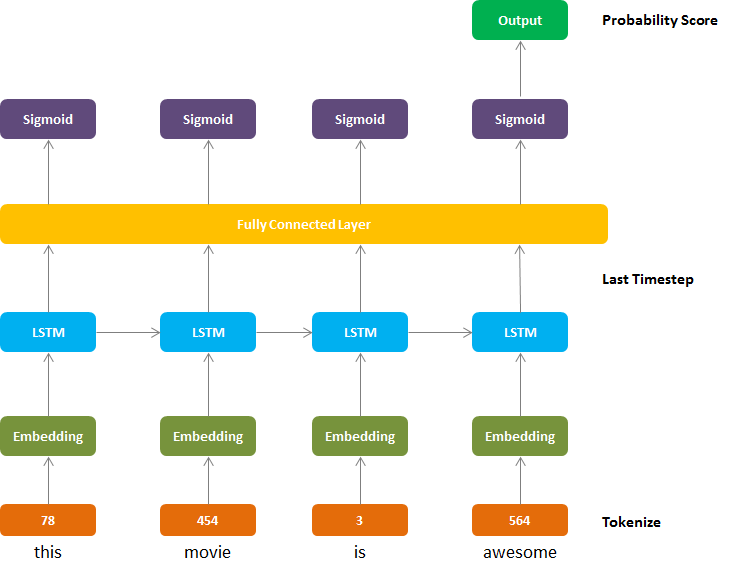

In [0]:
from IPython.display import Image
Image(filename='../img/sentiment.png') 
# source:(https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948)

In [0]:
from torchtext.datasets import IMDB
from torchtext import data
from torchtext.vocab import GloVe

from sklearn.metrics import confusion_matrix, f1_score, classification_report

seed = 42

#### pre-processing - tokenization & loaders

In [0]:
## create field - tokenize text & create label classes
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

# load dataset
train_data, test_data = IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 38.4MB/s]


In [0]:
# split training into train & validation
train_data, valid_data = train_data.split(split_ratio=0.8, random_state = np.random.seed(seed))

print('Training data size:   ', len(train_data))
print('Validation data size: ', len(valid_data))
print('Test data size:       ', len(test_data))

Training data size:    20000
Validation data size:  5000
Test data size:        25000


In [0]:
## build vocabulary - using top n words
# we do not want to remove stop words & punctuations though (since it removes context)
MAX_VOCAB_SIZE = 25000

# TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
# LABEL.build_vocab(train_data)

In [0]:
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [00:23, 36.7MB/s]                           
100%|█████████▉| 399448/400000 [00:38<00:00, 10463.07it/s]

In [0]:
## creating loader
# data loader equivalent in torchtext batch iterator - buckets similar lengths together
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = batch_size,
    device = device)

#### model implementation 

In [0]:
## Sentiment Analysis network
class SentimentNetwork(nn.Module):
    
    def __init__(self, n_input, n_embed, n_hidden, n_output, pretrained_vec=None):
        super().__init__()
        
        self.hidden_dim = n_hidden
        
        self.embedding = nn.Embedding(n_input, n_embed)
        if pretrained_vec is not None:
            self.embedding.weight.data.copy_(pretrained_vec)
            self.embedding.weight.requires_grad = False
            
        self.lstm = LSTM(ncell=1, input_dim=n_embed, hidden_dim=n_hidden, 
                         output_dim=None, bidirectional=False, xavier_init=True)
        self.fc = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, h, c):
        embed = self.embedding(x)
        output, c = self.lstm(embed, h, c)
        # getting latest hidden layer (for next iteration)
        h = output[:,:,-1:]
        y = self.fc(h)
        return y, h, c
      
## Sentiment Analysis network - using PyTorch LSTM module
class SentimentNetworkBaseline(nn.Module):
    
    def __init__(self, n_input, n_embed, n_hidden, n_output, pretrained_vec=None):
        super().__init__()
        
        self.hidden_dim = n_hidden
        
        self.embedding = nn.Embedding(n_input, n_embed)
        # not training embedding layer if pretrained embedding is provided
        if pretrained_vec is not None:
            self.embedding.weight.data.copy_(pretrained_vec)
            self.embedding.weight.requires_grad = False
            
        self.lstm = nn.LSTM(n_embed, n_hidden)
        self.fc = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, h, c):
        embed = self.embedding(x)
        output, (h, c) = self.lstm(embed, (h, c))
        y = self.fc(h.squeeze(0))
        return y, h, c

In [0]:
def train_sentiment(model, train_loader, device, epochs, optimizer, loss_criterion, valid_loader=None):
    """
    Trains the model of class LSTM using data from data_loader passed as argument
    
    Parameters
    ==========
    model: object of class torch.nn.Module
    train_loader: an object of class BucketIterator containing training data
        The next() function of the object returns a batch object, which has 2 members
        text   - which is a 3D tensor of [sequence, batch, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        labels - a 1D tensor of length batch_size containing the classes as integers (torch.long())
    valid_loader: Optional parameter, an object of class BucketIterator containing validation data.
        Similar to train_loader
        If passed, then it validates with the given data
    Returns
    =======
    Trained model object of class LSTM, list containing loss progress
    (, and list containing validation F1 score)
    
    """
    
    stats = {'loss': [], 'score': []}
    for i in range(epochs):
        loss_tracker = []
        
        model.train()
        for j, batch in enumerate(train_loader):
          
            # generate initial hidden & cell states
            hidden_state = torch.zeros(1, batch.label.shape[0], model.hidden_dim).to(device)
            cell_state = torch.zeros(1, batch.label.shape[0], model.hidden_dim).to(device)
            
            # forward pass
            output, _, _ = model(x=batch.text, 
                                 h=hidden_state, 
                                 c=cell_state)
            # backward pass for the batch (+ weight updates)
            optimizer.zero_grad()
            loss = loss_criterion(output.squeeze(1), batch.label)
            loss.backward()
            optimizer.step()
            
            print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, len(train_loader), 
                                                               loss.item()), end='\r')
            loss_tracker.append(loss.item())
        
        stats['loss'].append(np.mean(loss_tracker))
        loss_tracker = []
        print()
        print("Epoch #{}: Average loss is {}".format(i+1, stats['loss'][-1]))
        if valid_loader is not None:
            f1 = evaluate_sentiment(model, valid_loader, device, verbose=False)
            stats['score'].append(f1)
            print("Epoch #{}: Validation F1-score is {}".format(i+1, stats['score'][-1]))
        
        print()
    return model, stats
  

def evaluate_sentiment(model, test_loader, device, verbose=True):
    """
    Evaluates the model of class LSTM using test data passed
    
    Parameters
    ==========
    model: object of class LSTM
    test_data: a tuple containing (x, y) 
        x - a 3D tensor of [sequence, len_test_data, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        y - a 1D tensor containing the classes as integers (torch.long())
    verbose: prints the confusion matrix and F-score
    
    Returns
    =======
    F-score (float)
    
    """
    model.eval()
    
    preds = []
    labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            hidden_state = torch.zeros(1, batch.label.shape[0], model.hidden_dim).to(device)
            cell_state = torch.zeros(1, batch.label.shape[0], model.hidden_dim).to(device)
            output, _, _ = model(x=batch.text, h=hidden_state, c=cell_state)
            # get label predictions - since we predict only probabilities for label 1
            pred = torch.round(torch.sigmoid(output)).cpu().detach().numpy()
            preds.extend(pred)
            labels.extend(batch.label.cpu().detach().numpy())
            
    if verbose:
        print('Confusion Matrix: \n', confusion_matrix(labels, preds))
        print('Classification Report: \n', classification_report(labels, preds))
    return f1_score(labels, preds)

In [0]:
# create sentiment analysis model
modelSA = SentimentNetworkBaseline(n_input=len(TEXT.vocab), 
                                   n_embed=300,  # because of GloVe dims
                                   n_hidden=256, 
                                   n_output=1,   # it is enough if we predict only probabilities for label 1
                                   pretrained_vec=train_data.fields['text'].vocab.vectors)
modelSA.to(device)

optimizer = torch.optim.Adam(modelSA.parameters(), lr=0.001)
loss_criterion = nn.BCEWithLogitsLoss()

model, loss_list = train_sentiment(model=modelSA, 
                                   train_loader=train_iterator, 
                                   device=device,
                                   epochs=200,
                                   optimizer=optimizer,
                                   loss_criterion=loss_criterion,
                                   valid_loader=None)

Epoch #1: Batch 313/313 -- Loss = 0.6968051195144653
Epoch #1: Average loss is 0.6935135687882907
Epoch #1: Validation F1-score is 0.3563843563843564

Epoch #2: Batch 313/313 -- Loss = 0.6903514862060547
Epoch #2: Average loss is 0.6927292866828724
Epoch #2: Validation F1-score is 0.458153776366523

Epoch #3: Batch 313/313 -- Loss = 0.6938179135322571
Epoch #3: Average loss is 0.6923124710210977
Epoch #3: Validation F1-score is 0.600206611570248

Epoch #4: Batch 313/313 -- Loss = 0.6910571455955505
Epoch #4: Average loss is 0.6921767335349378
Epoch #4: Validation F1-score is 0.5424940428911835

Epoch #5: Batch 313/313 -- Loss = 0.6857484579086304
Epoch #5: Average loss is 0.6917159705878065
Epoch #5: Validation F1-score is 0.4087363494539782

Epoch #6: Batch 313/313 -- Loss = 0.689970850944519
Epoch #6: Average loss is 0.6910650434966286
Epoch #6: Validation F1-score is 0.6003603603603603

Epoch #7: Batch 313/313 -- Loss = 0.689975380897522
Epoch #7: Average loss is 0.690865975218459
E

ValueError: ignored

#### performance on validation & test data

In [72]:
valid_score = evaluate_sentiment(modelSA, valid_iterator, device)
print('Validation performance: %.4f' % valid_score)

Confusion Matrix: 
 [[2145  319]
 [ 352 2184]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      2464
         1.0       0.87      0.86      0.87      2536

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Validation performance: 0.8668


In [71]:
test_score = evaluate_sentiment(modelSA, test_iterator, device)
print('Test performance: %.4f' % test_score)

Confusion Matrix: 
 [[10743  1757]
 [ 1614 10886]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.86     12500
         1.0       0.86      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Test performance: 0.8659
